# Text Generation

This notebook covers:

1. How to load an LLM from HuggingFace?
2. How to generate a token from the model output tensors?
3. Prefill and decode: optimizing token generation over multiple steps



### Install dependencies

In [1]:
! git clone https://github.com/vikaskapur/my_genai_apps.git

#! pip install -r ../requirements.txt

Cloning into 'my_genai_apps'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 69 (delta 13), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (69/69), 24.76 KiB | 3.54 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
%cd my_genai_apps/llm_serving/
! pip install -r requirements.txt

/content/my_genai_apps/llm_serving
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.1 M

### Import required packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## 1. Load an LLM from HuggingFace?

- Load the LLM (GPT2)

In [2]:
#model_name = "./models/gpt2"
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

- Examine the model's architecture

In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## 2. Generate a token from the model output tensors

### Text Generation
- Start by tokenizing the input prompt

In [4]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

- Pass the inputs to the model and retrieve the logits to find the most likely next token

In [5]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


In [6]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

- Decode the most likely token

In [7]:
tokenizer.decode(next_token_id)

' fence'

- Print the 10 most likely next words

In [8]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

- Concatenate the input and most likely tokens

In [9]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [10]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


## 3. Prefill and decode: optimizing token generation over multiple steps

### Text generation helper function
- The following helper function generates the next tokens given a set of input tokens

In [11]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

- Use the helper function to generate multiple tokens in a loop
- Track the time it takes to generate each token

In [12]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(500):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

458.9408893585205 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' was', ' about', ' to', ' run', ' when', ' he', ' saw', ' the', ' fox', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' ot

- Plot token generation time
- The x-axis here is the token number
- The y-axis is the time to generate a token in millisenconds (ms)

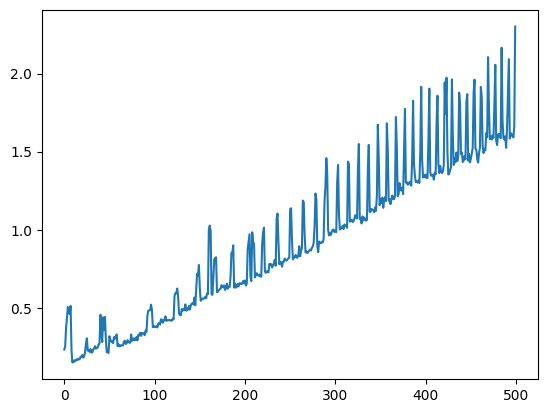

In [13]:
plt.plot(durations_s)
plt.show()

### Speeding up text generation with KV-caching
KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
- Modify the generate helper function to return the next token and the key/value tensors

In [14]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

- Generate 10 tokens using the updated helper function

In [15]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(500):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

30.098841905593872 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' was', ' about', ' to', ' run', ' when', ' he', ' saw', ' the', ' fox', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence', '.', ' He', ' ran', ' to', ' the', ' o

- Compare the execution time for the KV-cache function with the original helper function

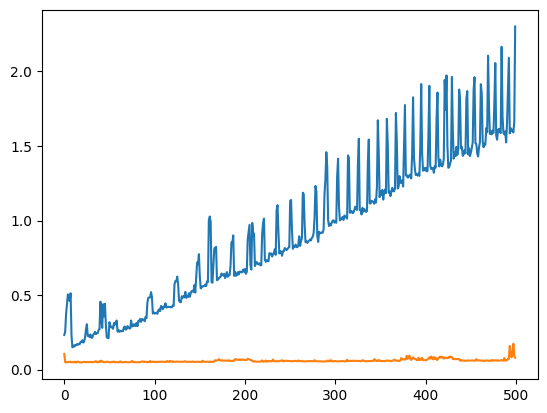

In [16]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()